In [1]:
import sys
sys.path.append('src')  # 添加 src 目录到系统路径

from target_cycliq import *

In [1]:
import os
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from PIL import Image as im

import numpy as np
import pandas as pd
import scipy

# --------------- font related start ---------------
font_path = "C:/Windows/font_others/times_simsun.ttf"
# font_path = "C:/Windows/font_others/arial_simhei.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
config = {
    'font.family': 'serif',
    'font.serif': [prop.get_name(), 'DejaVu Serif'],
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': [prop.get_name(), 'DejaVu Sans'],
    'font.size': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold'
}
rcParams.update(config)
# --------------- font related end ---------------

In [7]:
def plot_drained_torsion(temp_ax1,temp_ax2,test_file:str,simu_file:str,N_lim = 20):
    test_result = pd.read_table(test_file,sep=',')
    simu_result1 = pd.read_table(simu_file,sep=',')
    
    lw = 0.75
    color_simu = '#00449C'
    color_test = '#920A2F'
    test_trimmed = test_result[test_result['n'] < N_lim].copy()
    simu_trimmed = simu_result1[simu_result1['n'] < N_lim].copy()

    temp_ax1.plot(test_trimmed['n'],test_trimmed['gamma']*100,linewidth = lw, label = 'Test',color = color_test)
    temp_ax1.plot(simu_trimmed['n'],simu_trimmed['gamma']*100,linewidth = lw, label = 'CycLiq-M',color = color_simu)
    temp_ax2.plot(test_trimmed['n'],test_trimmed[  'e_v']*100,linewidth = lw, label = 'Test',color = color_test)
    temp_ax2.plot(simu_trimmed['n'],simu_trimmed[  'e_v']*100,linewidth = lw, label = 'CycLiq-M',color = color_simu)
    
    gamma_max = max(test_trimmed['gamma'].max(),
                    simu_trimmed['gamma'].max())
    gamma_min = min(test_trimmed['gamma'].min(),
                    simu_trimmed['gamma'].min())
    gamma_max = max(abs(gamma_max),abs(gamma_min))
    ev_max = max(test_trimmed['e_v'].max(),
                 simu_trimmed['e_v'].max())
    ev_min = min(test_trimmed['e_v'].min(),
                 simu_trimmed['e_v'].min())

    for axi in [temp_ax1]:
        axi.set_xlim([0,20])
        axi.set_ylim([-120*gamma_max,120*gamma_max])
        axi.set_xlabel(r'$N_{cycles}$')
        axi.set_ylabel(r'$\gamma \ (\%)$')
        # axi.legend(frameon = 0,loc = 'lower right')
    for axi in [temp_ax2]:
        axi.set_xlim([0,20])
        axi.set_ylim([120*ev_min,120*ev_max])
        axi.set_xlabel(r'$N_{cycles}$')
        axi.set_ylabel(r'$e_v \ (\%)$')
        axi.legend(frameon = 0,loc = 'upper left')

def plot_undrained_torsion(temp_ax1,temp_ax2,test_file:str,simu_file:str,DA_lim = 0.075):
    if os.path.exists(test_file) and os.path.exists(simu_file):
        test_result = pd.read_table(test_file,sep=',')
        simu_result1 = pd.read_table(simu_file,sep=',')
        
        lw = 0.75
        color_simu = '#00449C'
        color_test = '#920A2F'
        
        test_result['DA'] = calculate_DA(test_result['gamma'].tolist())
        simu_result1['DA'] = calculate_DA(simu_result1['gamma'].tolist())
        test_trimmed = test_result[test_result['DA']<DA_lim].copy()
        simu_trimmed = simu_result1[simu_result1['DA']<DA_lim].copy()
    
        temp_nmax = max(test_trimmed['n'].max(),simu_trimmed['n'].max())
    
        temp_ax1.plot(test_trimmed['n'],test_trimmed['gamma']*100,linewidth = lw, label = 'Test',color = color_test)
        temp_ax1.plot(simu_trimmed['n'],simu_trimmed['gamma']*100,linewidth = lw, label = 'CycLiq-M',color = color_simu)
        # temp_ax1.plot(test_trimmed['n'],test_trimmed['DA']*100,linewidth = lw, label = 'Test',color = color_test)
        # temp_ax1.plot(simu_trimmed['n'],simu_trimmed['DA']*100,linewidth = lw, label = 'CycLiq-M',color = color_simu)
        temp_ax2.plot(test_trimmed['n'],test_trimmed[  'p'],linewidth = lw, label = 'Test',color = color_test)
        temp_ax2.plot(simu_trimmed['n'],simu_trimmed[  'p'],linewidth = lw, label = 'CycLiq-M',color = color_simu)
        
        gamma_max = max(test_trimmed['gamma'].max(),
                        simu_trimmed['gamma'].max())
        gamma_min = min(test_trimmed['gamma'].min(),
                        simu_trimmed['gamma'].min())
        gamma_max = max(abs(gamma_max),abs(gamma_min))
        p_max = max(test_result['p'].max(),
                        simu_result1['p'].max())
    
    
        for axi in [temp_ax1]:
            axi.set_xlim([0,temp_nmax*1.1])
            axi.set_ylim([-5,5])
            axi.set_xlabel(r'$N_{cycles}$')
            axi.set_ylabel(r'$\gamma \ (\%)$')
            # axi.legend(frameon = 0,loc = 'lower right')
        for axi in [temp_ax2]:
            axi.set_xlim([0,temp_nmax*1.1])
            axi.set_ylim([0,1.1*p_max])
            axi.set_xlabel(r'$N_{cycles}$')
            axi.set_ylabel(r'$p \ (kPa)$')
            axi.legend(frameon = 0,loc = 'upper right')
    else:
        print('Problem occurred! A png lacked!')

In [45]:
# ottawa_undrained_HCA_config = [
#     [100, 0.647, 0.127],
#     [100, 0.647, 0.147],
#     [100, 0.619, 0.174],
#     [100, 0.612, 0.199],
#     [100, 0.593, 0.200],
#     [100, 0.587, 0.248],
#     [100, 0.591, 0.272],
#     [100, 0.558, 0.296],
#     [100, 0.553, 0.391]
# ]

ottawa_undrained_HCA_config = [
    [100, 0.619, 0.174],
    [100, 0.612, 0.199],
]

ottawa_drained_HCA_config = [
    [200, 0.588, 0.170],
    [200, 0.589, 0.250]
]

temp_dict = {'undrained_cyclic_HCT': ottawa_undrained_HCA_config}
test_exp = ExpTarget(temp_dict)

check_folder = 'kappa check/test2/'

# test_exp.ini_simu(simu_folder = check_folder)

# ['G0', 'Kappa', 'h', 'M', 'dre1', 'dre2', 'rdr', 'eta', 'dir', 'lambdac', 'ksi', 'e0', 'nb', 'nd', 'beta1', 'beta2']
# test_exp.conduct_simu([210, 0.0023, 1.5, 1.1, 
#                        0.025, # dre1
#                        30,
#                        0.05, 
#                        3000, # alpha
#                        0.8,
#                        0.0112, 0.715, 0.78, 2.2, 6, 9, 6],
#                       simu_folder = check_folder)
test_exp.conduct_simu([210, 0.0023, 1.5, 1.1, 
                       0.025, # dre1
                       30,
                       0.05, 
                       3000, # alpha
                       0.8,
                       0.0112, 0.715, 0.78, 2.2, 6, 9, 6],
                      simu_folder = check_folder)

plot_by_name('target_exp/ottawa/',check_folder,'temp.png')

In [18]:
def plot_by_name(test_folder,simu_folder,png_name):
    img_width = 17 # in centimeters
    img_ratio = 1/2.2
    
    fig = plt.figure(figsize = (img_width/2.54,img_width/img_ratio/2.54))
    gs = gridspec.GridSpec(nrows=10, ncols=2, top=0.95,bottom=0.0,right=0.96,left=0.10,wspace = 0.2,hspace=0.42)
    ax1  = fig.add_subplot(gs[0, 0])
    ax2  = fig.add_subplot(gs[0, 1])
    ax3  = fig.add_subplot(gs[1, 0])
    ax4  = fig.add_subplot(gs[1, 1])
    ax5  = fig.add_subplot(gs[2, 0])
    ax6  = fig.add_subplot(gs[2, 1])
    ax7  = fig.add_subplot(gs[3, 0])
    ax8  = fig.add_subplot(gs[3, 1])
    ax9  = fig.add_subplot(gs[4, 0])
    ax10  = fig.add_subplot(gs[4, 1])
    ax11  = fig.add_subplot(gs[5, 0])
    ax12  = fig.add_subplot(gs[5, 1])
    ax13  = fig.add_subplot(gs[6, 0])
    ax14  = fig.add_subplot(gs[6, 1])
    ax15  = fig.add_subplot(gs[7, 0])
    ax16  = fig.add_subplot(gs[7, 1])
    ax17  = fig.add_subplot(gs[8, 0])
    ax18  = fig.add_subplot(gs[8, 1])
    ax0  = fig.add_subplot(gs[9, :])
    
    # plot_para_table(ax0,para)
    
    plot_drained_torsion(ax1,ax2,
                         test_folder+'drained_HCT_p_200_ein_0_588_csr_0_170.txt',
                         simu_folder+'drained_HCT_p_200_ein_0_588_csr_0_170.txt')
    
    plot_drained_torsion(ax3,ax4,
                         test_folder+'drained_HCT_p_200_ein_0_589_csr_0_250.txt',
                         simu_folder+'drained_HCT_p_200_ein_0_589_csr_0_250.txt')
    
    
    plot_undrained_torsion(ax5,ax6,
                         test_folder+'undrained_HCT_p_100_ein_0_612_csr_0_199.txt',
                         simu_folder+'undrained_HCT_p_100_ein_0_612_csr_0_199.txt')
    
    plot_undrained_torsion(ax7,ax8,
                         test_folder+'undrained_HCT_p_100_ein_0_619_csr_0_174.txt',
                         simu_folder+'undrained_HCT_p_100_ein_0_619_csr_0_174.txt')
    
                        
    fig.savefig(png_name,dpi = 300)
    plt.close()

plot_by_name('target_exp/ottawa/','target_exp/ottawa_simu/','temp.png')

In [35]:
plot_by_name('target_exp/ottawa/',check_folder,'temp.png')

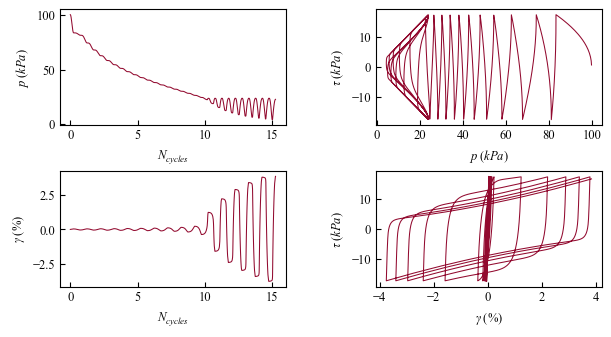

In [2]:
# txtfile = 'target_exp/ottawa_simu/undrained_HCT_p_100_ein_0_619_csr_0_174.txt'
txtfile = 'kappa check/test2/undrained_HCT_p_100_ein_0_619_csr_0_174.txt'

# 根据需要截取片段
temp_df = pd.read_csv(txtfile)

img_width = 16 # in centimeters
img_ratio = 2/1.1

fig = plt.figure(figsize = (img_width/2.54,img_width/img_ratio/2.54))
gs = gridspec.GridSpec(nrows=2, ncols=2, top=0.95,bottom=0.15,right=0.96,left=0.10,wspace = 0.4,hspace=0.4)
ax1  = fig.add_subplot(gs[0, 0])
ax2  = fig.add_subplot(gs[1, 0])
ax3  = fig.add_subplot(gs[0, 1])
ax4  = fig.add_subplot(gs[1, 1])

lw = 0.75
color_test = '#920A2F'

# 加载周次：'ncyc'
# 应力对应的索引：'s_z','s_r','s_t','s_zt','s_1','s_2','s_3','p','q','tau','b','alpha'
# 应变对应的索引：'e_z','e_r','e_t','e_zt','e_1','e_2','e_3','e_v','e_q','gamma'

ax1.plot(temp_df['n'],temp_df['p'],linewidth = lw, label = 'Test',color = color_test)
ax1.set_xlabel(r'$N_{cycles}$')
ax1.set_ylabel(r'$p \ (kPa)$')

ax2.plot(temp_df['n'],temp_df['gamma']*100,linewidth = lw, label = 'Test',color = color_test)
ax2.set_xlabel(r'$N_{cycles}$')
ax2.set_ylabel(r'$\gamma \ (\%)$')

ax3.plot(temp_df['p'],temp_df['tau'],linewidth = lw, label = 'Test',color = color_test)
ax3.set_xlabel(r'$p \ (kPa)$')
ax3.set_ylabel(r'$\tau \ (kPa)$')

ax4.plot(temp_df['gamma']*100,temp_df['tau'],linewidth = lw, label = 'Test',color = color_test)
ax4.set_xlabel(r'$\gamma \ (\%)$')
ax4.set_ylabel(r'$\tau \ (kPa)$')

plt.savefig('temp.png',dpi=300)

In [5]:
temp_df['q']/temp_df['p']

0        0.012480
1        0.024646
2        0.036530
3        0.048160
4        0.059559
           ...   
63286    1.268592
63287    1.268589
63288    1.268586
63289    1.268589
63290    1.268586
Length: 63291, dtype: float64

## M, np

In [1]:
from src.target_cycliq import ParaTrans, ExpTarget, EvalCycliq
from src.eval_sedata import eval_undrained_cyc_torsion, eval_drained_cyc_torsion
from src.opt_pso2 import pso
import time, os, shutil
import pandas as pd

In [2]:
import os
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from PIL import Image as im

import numpy as np
import pandas as pd
import scipy

# --------------- font related start ---------------
font_path = "C:/Windows/font_others/times_simsun.ttf"
# font_path = "C:/Windows/font_others/arial_simhei.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
config = {
    'font.family': 'serif',
    'font.serif': [prop.get_name(), 'DejaVu Serif'],
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': [prop.get_name(), 'DejaVu Sans'],
    'font.size': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold'
}
rcParams.update(config)
# --------------- font related end ---------------

In [3]:
from typing import List, Dict, Tuple, Union, Callable
from matplotlib.axes import Axes

def plot_by_list(data_df: pd.DataFrame, plot_config: List[Tuple[Axes, str, str]], color: str, label: str = '', lw :float = 0.75):
    label_dict = {
        'p': r'$p \ (kPa)$',
        'q': r'$q \ (kPa)$',
        'tau': r'$\tau \ (kPa)$',
        'e_a': r'$\epsilon_{axial} \ (\%)$',
        'e_v': r'$\epsilon_{v} \ (\%)$',
        'e_q': r'$\epsilon_{q} \ (\%)$',
        'gamma': r'$\gamma \ (\%)$',
        'n': r'$N_{cycles}$',
        'e': r'$e$',
        'ru':r'$r_u$'
    }
    for ax_i, var1, var2 in plot_config:
        data_x = data_df[var2]
        data_y = data_df[var1]
        if var2 in ['e_a','e_v','gamma','e_q']:
            data_x = data_x * 100
        if var1 in ['e_a','e_v','gamma','e_q']:
            data_y = data_y * 100
        ax_i.plot(data_x, data_y, linewidth = lw, label = label,color = color)
        ax_i.set_xlabel(label_dict[var2])
        ax_i.set_ylabel(label_dict[var1])

def calculate_DA(temp_gamma: List[float]) -> List[float]:
    """
    Calculate the double amplitude strain (DA) for a given list of strains.
    
    The function computes the difference between the cumulative maximum and minimum 
    strains at each point in the list, which represents the DA at that point.

    Parameters:
    - temp_gamma (List[float]): List of strain values, typically 'gamma' from a DataFrame.

    Returns:
    - List[float]: List of DA values corresponding to each strain in 'temp_gamma'.
    """
    if not temp_gamma:
        return []

    list_DA = []
    temp_min = temp_gamma[0]
    temp_max = temp_gamma[0]

    # Initialize the first element as the difference of the same element
    list_DA.append(0.0)

    # Compute the DA starting from the second element
    for gamma_i in temp_gamma[1:]:
        temp_min = min(temp_min, gamma_i)
        temp_max = max(temp_max, gamma_i)
        list_DA.append(temp_max - temp_min)

    return list_DA

In [7]:
test_exp1 = {
    'undrained_cyclic_HCT_5cyc':[
        [10, 0.593, 2.000],
        [10, 0.612, 1.990],
    ],
}

if True:
    # 目标试验的定义
    exp_folder='target_exp/ottawa_simu/'
    test_exp = ExpTarget(test_exp1)
    check_folder = 'kappa check/test_smallp/'

para_list = [120, # G0
             0.015, # Kappa
             2.0, # h
             1.22, # M
             0.5, # dre1
             30, # dre2
             0.01, # rdr
             30, # alpha
             0.1, # dir
             0.048, # lambdac
             0.9, # ksi
             1.07, # e0
             0.9, # nb
             0.7, # nd
             6, # beta1
             0 ]

para_list = [210, 0.01, 1.5, 1.1, 1.4, 30, 0.05, 30, 0.43, 0.0112, 0.715, 0.78, 2.2, 6, 9, 6]

test_exp.conduct_simu(para_list,
                      simu_folder = check_folder)